In [1]:
import time, json, glob, os
from py2neo import Graph, Node, Relationship
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
%matplotlib inline

In [2]:
graph = Graph( "bolt://matlaber5.media.mit.edu:7687", auth=('neo4j','myneo'))
print("Connected to graph database with {:,} nodes and {:,} relationships!".format(
    graph.database.primitive_counts['NumberOfNodeIdsInUse'], 
    graph.database.primitive_counts['NumberOfRelationshipIdsInUse']))

Connected to graph database with 278,432,359 nodes and 1,844,501,832 relationships!


In [3]:
def query_to_df(query, graph):
    print("Starting query...", end=" ")
    query_start_time = time.time()
    df = graph.run(query).to_data_frame()
    print("Done ({:.2f} minutes).".format((time.time()-query_start_time)/60))
    return df
    
top_5 = ['Cell', 'Nature', 'Nature Biotechnology','Proceedings of the National Academy of Sciences of the United States of America','Science']
top_10 = ['Cell', 'Nature', 'Nature Biotechnology','Proceedings of the National Academy of Sciences of the United States of America','Science', 'Journal of the American Chemical Society', 'JAMA', 'The New England Journal of Medicine', 'Nature Genetics', 'Neuron']
top_42 = ['Angewandte Chemie','Blood','Cancer Cell','Cancer Discovery','Cancer Research','Cell','Cell Host & Microbe','Cell Metabolism','Cell Stem Cell','Chemistry & Biology','The EMBO Journal','Genes & Development','Immunity','Journal of Neurology','Journal of the American Chemical Society','JAMA','Journal of Biological Chemistry','Journal of Cell Biology','Journal of Clinical Investigation','Journal of Experimental Medicine','Journal of Medicinal Chemistry','The Lancet','Nature Cell Biology','Nature Chemical Biology','Nature Chemistry','Nature Medicine','Nature Methods','Nature','Nature Biotechnology','The New England Journal of Medicine','Neuron','Nature Genetics','Nature Immunology','Nature Neuroscience','Nature Structural & Molecular Biology','PLOS Biology','PLOS Genetics','PLOS Pathogens','Proceedings of the National Academy of Sciences of the United States of America','Science Signaling','Science Translational Medicine','Science']

In [6]:
query = """
MATCH (q:Quanta)
WHERE q.venue in {}
RETURN q.id, q.Disruption as disruption, q.num_profs_v2 as num_profs, q.articleRank2018 as articlerank, q.pageRank_2018 as pagerank
""".format(top_42)
df = query_to_df(query, graph)

Starting query... Done (16.13 minutes).


In [8]:
df.to_csv('C:\\Users\\Brend\\Downloads\\article_level_top42.csv', index = False, encoding = "UTF-8")

In [4]:
df = pd.read_csv('C:\\Users\\Brend\\Downloads\\article_level_top42.csv', index_col = 'q.id', encoding = 'UTF-8')

In [68]:
print("Before trimming: %d authors" % df.shape[0])
df_trimmed = df[df['num_profs'] < 100]
print("Remaining after trimming: %d authors" % df_trimmed.shape[0])

Before trimming: 2037922 authors
Remaining after trimming: 1940303 authors


In [69]:
df_log = df_trimmed.copy()
for col in df_trimmed.columns:
    log_col = df_log[[col]]
    df_log[col + '_log'] = log_col.apply(np.log, axis=0)
df_log = df_log[[col for col in df_log.columns if 'log' in col]]

In [70]:
df_log_adjusted = df_trimmed.copy()
for col in df_trimmed.columns:
    log_col = df_log_adjusted[[col]]
    df_log_adjusted[col + '_log_adj'] = log_col.apply(lambda x: np.log(x+1), axis=0)
df_log_adjusted = df_log_adjusted[[col for col in df_log_adjusted.columns if 'log' in col]]

In [71]:
from sklearn.preprocessing import StandardScaler
df_scaled = df_trimmed.copy()
for col in df_trimmed.columns:
    ss = StandardScaler()
    scaled_col = df_scaled[[col]]
    df_scaled[col + '_zscore'] = ss.fit_transform(scaled_col)
df_zscores = df_scaled[[col for col in df_scaled.columns if 'zscore' in col]]

In [72]:
disrupt = ['disruption']
impact = ['articlerank', 'pagerank']
num_profs = ['num_profs']

In [73]:
processing = dict()
processing['disruption'] = 'log_adj'
processing['num_profs'] = 'zscore'
processing['articlerank'] = 'log'
processing['pagerank'] = 'log'
df_table = {'zscore': df_zscores, 'log': df_log, 'log_adj': df_log_adjusted}

In [74]:
def plot(cols, log_scale = False):
    for x_col in cols:
        X = df_table[processing[x_col]][[x_col + '_' + processing[x_col]]]
        df_X_notinf = X.replace([np.inf, -np.inf], np.nan)
        df_X_notna = df_X_notinf.dropna(subset=[x_col + '_' + processing[x_col]])
        ax = sns.distplot(df_X_notna, kde = False, axlabel = x_col, bins = 100)
        if log_scale:
            ax.set_yscale('log')
        plt.show()

In [75]:
def joint_plot(x_cols, y_cols):
    for x_col in x_cols:
        for y_col in y_cols:   
            X = df_table[processing[x_col]][[x_col + '_' + processing[x_col]]]
            y = df_table[processing[y_col]][[y_col + '_' + processing[y_col]]]
            df_X_notinf = X.replace([np.inf, -np.inf], np.nan)
            df_y_notinf = y.replace([np.inf, -np.inf], np.nan)
            df_X_notna = df_X_notinf.dropna(subset=[x_col + '_' + processing[x_col]])
            df_y_notna = df_y_notinf.dropna(subset=[y_col + '_' + processing[y_col]])
            df_reg = df_X_notna.join(df_y_notna, how = 'inner')
            X = df_reg[[x_col + '_' + processing[x_col]]]
            y = df_reg[[y_col + '_' + processing[y_col]]]
            data = pd.concat([X, y], axis=1)
            f, ax = plt.subplots(figsize=(8,8))
            g = sns.regplot(x_col + '_' + processing[x_col], y_col + '_' + processing[y_col], data, ax=ax, dropna = True, fit_reg=False, scatter_kws={"color":"darkred","alpha":0.3,"s":1})
            plt.show()

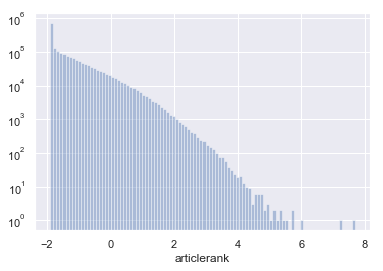

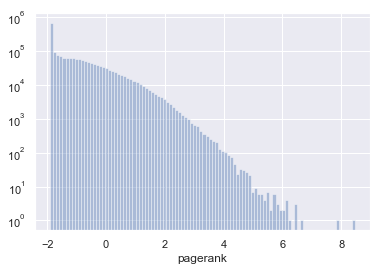

In [65]:
plot(impact, log_scale = True)

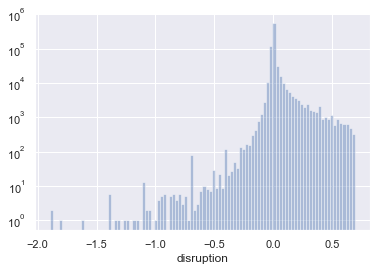

In [66]:
plot(disrupt, log_scale = True)

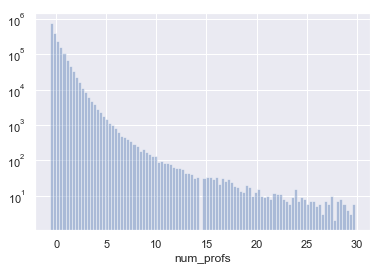

In [76]:
plot(num_profs, log_scale = True)

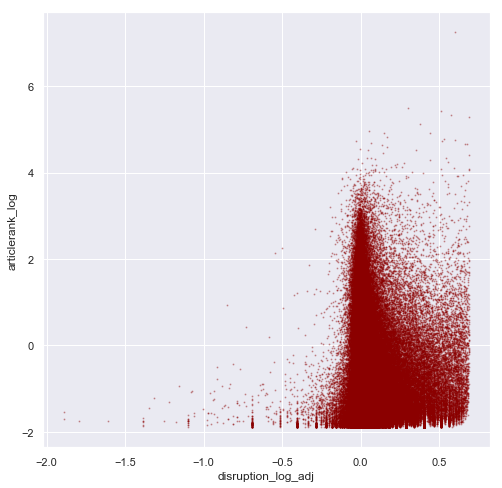

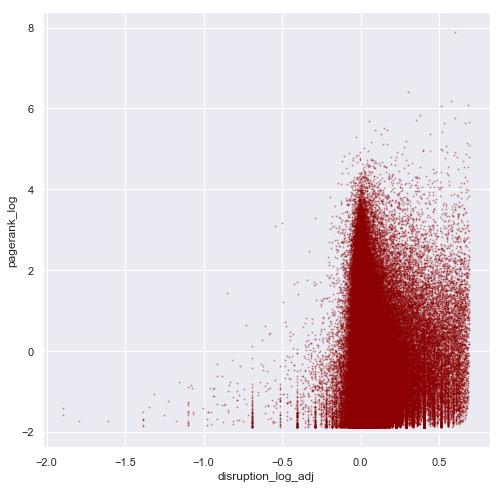

In [33]:
joint_plot(disrupt, impact)

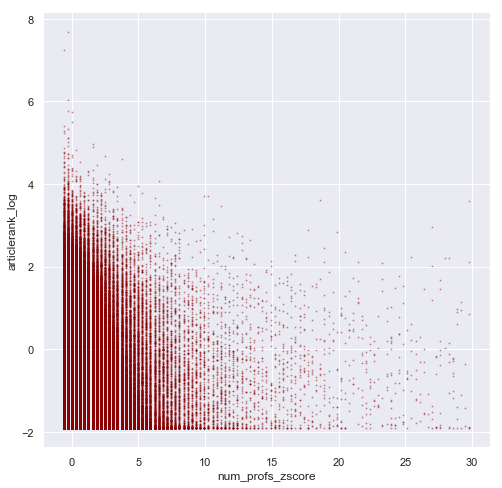

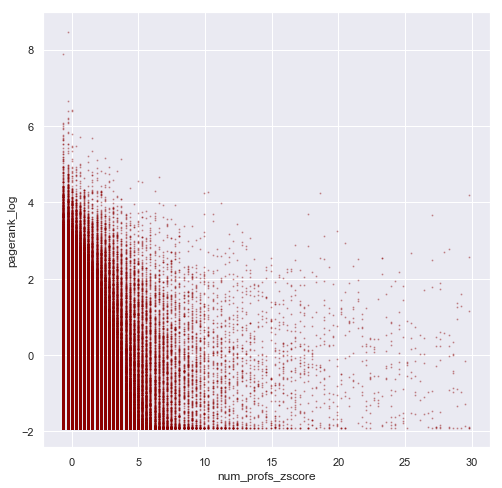

In [77]:
joint_plot(num_profs, impact)

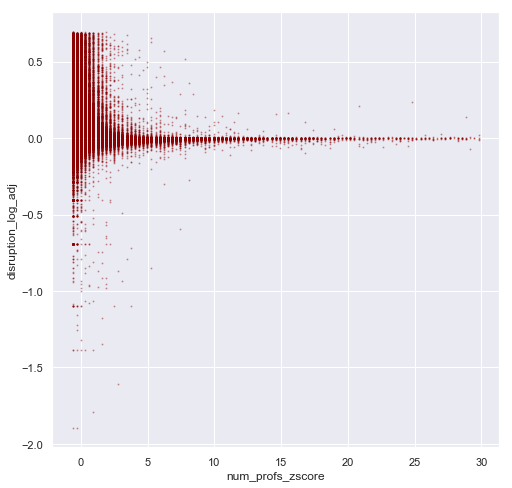

In [78]:
joint_plot(num_profs, disrupt)